In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import add_constant
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
import graphviz
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline
#matplotlib.rc('font', family = "NanumGothic")
#plt.rc('font', family = "NanumGothic")
#plt.rcParams["font.family"] = 'NanumGothic'
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import os
os.chdir("C:/Users/PIAI/Downloads/실습화일/2. Big Data 분석")
os.getcwd()
df_raw = pd.read_csv("SCALE불량.csv", encoding="cp949")

# Data processing

In [ ]:
df_raw.head()

In [ ]:
df_raw.info()

In [ ]:
# 사전 조사에 의하여 목표변수와 일절 상관없다고 여겨지는 열 삭제
df_raw = df_raw.drop(df_raw.columns[[0,1,3,4,11,21]], axis='columns')

In [ ]:
df_raw.describe()

In [ ]:
#결측치 확인
df_raw.isnull().sum()

In [ ]:
def defect(x):
    if x == "불량":
        return 1
    else:
        return 0

In [ ]:
# scale열이 '음성', '양성' 을 정수에 대입시켜 변환시켜준다
df_raw['scale'] = df_raw['scale'].apply(defect)
df_raw.head()

In [ ]:
# 데이터에서 목표변수인 scale의 불량과 정상 비율을 확인
df_raw.scale.value_counts(normalize=True)

In [ ]:
# 설명변수 중 object형이 변수 확인
print(df_raw['hsb'].unique())
print(df_raw['fur_no'].unique())
print(df_raw['rolling_method'].unique())

In [ ]:
df_raw.info()

In [ ]:
cols = ['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time']
data = df_raw[cols]
# 5개 열에 대한 boxplot을 그리기 위한 5개의 Axes 생성
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

# 각 Axes에 대해 boxplot 그리기
for i, ax in enumerate(axes):
    sns.boxplot(y=data[cols[i]], ax=ax)
    ax.set_xlabel(cols[i])

# 그래프 출력
plt.show()

In [ ]:
cols = ['fur_soak_temp', 'fur_total_time', 'fur_ex_temp', 'rolling_temp', 'descaling_count']
data = df_raw[cols]
# 5개 열에 대한 boxplot을 그리기 위한 5개의 Axes 생성
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

# 각 Axes에 대해 boxplot 그리기
for i, ax in enumerate(axes):
    sns.boxplot(y=data[cols[i]], ax=ax)
    ax.set_xlabel(cols[i])

# 그래프 출력
plt.show()

In [ ]:
# pt_thick 열에서 300 이상인 행 삭제
df_raw = df_raw[df_raw['pt_thick'] < 90]

# rolling_temp 열에서 100 이하인 행 삭제
df_raw = df_raw[df_raw['rolling_temp'] > 100]

In [ ]:
df_raw.describe()

In [ ]:
# pt_width, rolling_temp 열 데이터 가져오기
cols = ['pt_width', 'rolling_temp']
data = df_raw[cols]
# 5개 열에 대한 boxplot을 그리기 위한 5개의 Axes 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

# 각 Axes에 대해 boxplot 그리기
for i, ax in enumerate(axes):
    sns.boxplot(y=data[cols[i]], ax=ax)
    ax.set_xlabel(cols[i])

# 그래프 출력
plt.show()

In [ ]:
#파생 변수 생성
# 크기 = 후판 지시두꼐*(지시폭+지시길이)
df_raw['size'] = df_raw['pt_thick'] *(df_raw['pt_width'] + df_raw['pt_length'])
df_raw = df_raw.drop(['pt_thick', 'pt_width', 'pt_length'], axis=1)

# 탐색적 분석

In [ ]:
df_raw.columns

In [ ]:
def chisquare(col, name):
    # 빈도수를 계산하고 값이 0인 셀이 없는지 확인
    #contingency_table = pd.crosstab(col, df_raw['scale'], margins = True)
    contingency_table =pd.crosstab(df_raw["scale"], df_raw[name], margins=True)
    print("Contingency Table:")
    print(contingency_table)
    print()
    # 카이제곱 검정 수행
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

    # 결과 출력
    print("카이제곱 통계량: {:.2f}".format(chi2))
    print("P-값: {:.2f}".format(p_value))

    if p_value < 0.05:
        print(" scale에 영향을 미칩니다.")
    else:
        print(" scale에 영향을 미치지 않습니다.")

In [ ]:
chisquare(df_raw['hsb'],'hsb')

In [ ]:
chisquare(df_raw['fur_no'], 'fur_no')

In [ ]:
df_raw.drop("fur_no", axis=1, inplace = True)

In [ ]:
chisquare(df_raw['rolling_method'], 'rolling_method')

In [ ]:
chisquare(df_raw['steel_kind'], 'steel_kind')

# 모델 생성

## 1. 로지스틱 회귀

In [ ]:
df_train, df_test = train_test_split(df_raw, test_size=0.3, random_state=1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

In [ ]:
df_train['scale'].value_counts(normalize=True), df_test['scale'].value_counts(normalize=True)

In [ ]:
df_train.info()

In [ ]:
log_model = Logit.from_formula("scale ~ C(steel_kind)+ C(hsb)+ fur_heat_temp+ fur_heat_time+\
       fur_soak_temp+ fur_soak_time+ fur_total_time+ fur_ex_temp+\
       rolling_temp+ descaling_count+ size+C(rolling_method)", df_train)
                               
log_result = log_model.fit()
print(log_result.summary())

In [ ]:
y_pred_train = log_result.predict(df_train)
y_pred_train_class = (y_pred_train>0.5).astype(int)

y_pred_test = log_result.predict(df_test)
y_pred_test_class = (y_pred_test>0.4).astype(int)

print('Trian 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train['scale'], y_pred_train_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['scale'], y_pred_train_class)),'\n')
print(classification_report(df_train['scale'], y_pred_train_class,target_names = ['승인', '거절'] ,digits=3))

print('Test 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test['scale'], y_pred_test_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test['scale'], y_pred_test_class)),'\n')
print(classification_report(df_test['scale'], y_pred_test_class,target_names = ['양성', '음성'], digits=3))

In [ ]:
df_logistic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef')

------------

In [ ]:
df_scale = df_raw.drop("hsb", axis=1)

In [ ]:
df_char = df_scale.select_dtypes(include = 'object')
df_numeric = df_scale.select_dtypes(exclude = 'object')

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis = 1)
df_scaled.head()

In [ ]:
df_scaled['scale'] = np.where(df_scaled['scale']>0, 1, 0)
df_scaled.isnull().sum()

In [ ]:
df_scaled = df_scaled.fillna(df_scaled.mean())

In [ ]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

스케일링 과정에서 나누기 연산이 발생할 경우 일부 값이 무한대(inf)로 표현되거나 결측값(NaN)이 발생할 수 있습니다. 이는 주로 분산이 0인 경우 발생합니다. 이 경우, 무한대 값을 결측값으로 변환한 다음, 결측값 처리를 수행해야 합니다.

In [ ]:
print(df_scaled_train.isnull().sum())
print((df_scaled_train == np.inf).sum())
print((df_scaled_train == -np.inf).sum())

In [ ]:
df_scaled = df_scaled.dropna()

In [ ]:
scaled_log_model = Logit.from_formula("scale ~ C(steel_kind)+ fur_heat_temp+ fur_heat_time+\
       fur_soak_temp+ fur_soak_time+ fur_total_time+ fur_ex_temp+\
       rolling_temp+ descaling_count+ size+C(rolling_method)", df_scaled_train)
                               
scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

In [ ]:
df_log_scaled_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = 'Coef', legend = False)

In [ ]:
y_pred_train = scaled_log_result.predict(df_train)
y_pred_train_class = (y_pred_train>0.4).astype(int)

y_pred_test = log_result.predict(df_test)
y_pred_test_class = (y_pred_test>0.4).astype(int)

print('Trian 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train['scale'], y_pred_train_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['scale'], y_pred_train_class)),'\n')
print(classification_report(df_train['scale'], y_pred_train_class,target_names = ['양성', '음성'] ,digits=3))

print('Test 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test['scale'], y_pred_test_class)))
logit_confusion = confusion_matrix(df_test['scale'], y_pred_test_class)
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test['scale'], y_pred_test_class)),'\n')
logit_creport = classification_report(df_test['scale'], y_pred_test_class,target_names = ['양성', '음성'], digits=3)
print(classification_report(df_test['scale'], y_pred_test_class,target_names = ['양성', '음성'], digits=3))

## 2. 의사결정나무

In [ ]:
# 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

df_raw_x = df_raw_dummy.drop('scale', axis =1, inplace = False)
df_raw_y = df_raw_dummy['scale']

In [562]:
#데이터는 (train(0.6) : test(0.4))의 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (692, 15)
train data Y size: (692,)
test data X size: (297, 15)
test data Y size: (297,)


In [563]:
df_raw_y.value_counts(normalize=True)
#원 데이터에서 0(음성)인 데이터가 1(양성)인 데이터에 비해서 2배 정도 많다

0    0.688574
1    0.311426
Name: scale, dtype: float64

In [565]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto')
x_resampled, y_resampled = sm.fit_resample(df_train_x, df_train_y)

print('over-sampling 전 : \n', df_train_y.value_counts(), '\n')
print('over-sampling 후 : {}'.format(x_resampled.shape))
print('over-sampling 후 : {}\n'.format(y_resampled.shape))
print('over-sampling 후 1 : {}'.format(sum(y_resampled==1)))
print('over-sampling 후  0 : {}'.format(sum(y_resampled==0)))

over-sampling 전 : 
 0    472
1    220
Name: scale, dtype: int64 

over-sampling 후 : (944, 15)
over-sampling 후 : (944,)

over-sampling 후 1 : 472
over-sampling 후  0 : 472


In [567]:
df_resempled = pd.concat([x_resampled, y_resampled], axis = 1)

In [589]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.993


In [570]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {
    "max_depth": sp_randint(1, 20),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "max_features": [1.0],
    "criterion": ['gini', 'entropy', 'log_loss']
}

dt = DecisionTreeClassifier()

random_dt = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=10, cv=3, scoring="r2", random_state=42)
random_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(random_dt.best_estimator_))
print("\nbest parameter: \n{}".format(random_dt.best_params_))
print("\nbest score: \n{}".format(random_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=9, max_features=1.0, min_samples_leaf=7,
                       min_samples_split=19)

best parameter: 
{'criterion': 'gini', 'max_depth': 9, 'max_features': 1.0, 'min_samples_leaf': 7, 'min_samples_split': 19}

best score: 
0.913


In [572]:
tree_final = DecisionTreeClassifier(min_samples_leaf=7,min_samples_split=19,max_depth=9, random_state=1234)
tree_final.fit(df_train_x, df_train_y)


print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.993
Score on test set: 0.993


In [573]:
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
6,rolling_temp,0.541
11,hsb_미적용,0.163
2,fur_soak_temp,0.153
7,descaling_count,0.100
5,fur_ex_temp,0.042
4,fur_total_time,0.001
0,fur_heat_temp,0.000
1,fur_heat_time,0.000
3,fur_soak_time,0.000
8,size,0.000


Text(0, 0.5, '변수')

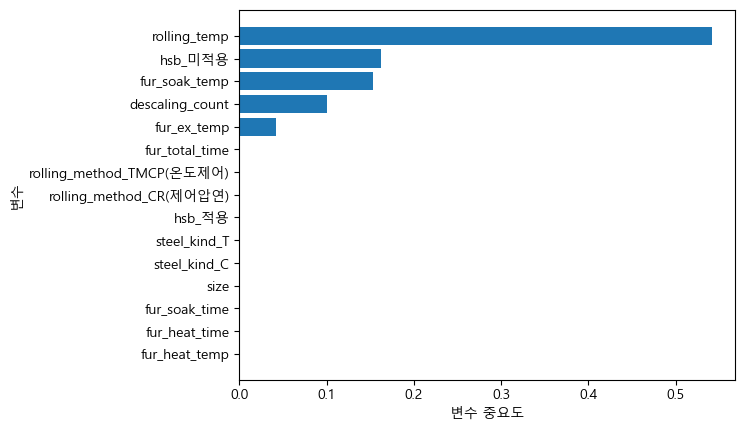

In [574]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [590]:
# Over-sampling Data를 이용한 모델링 및 평가
df_train_x_over, df_test_x_over, df_train_y_over, df_test_y_over = train_test_split(x_resampled, y_resampled,\
                                                                                   test_size = 0.4, stratify = y_resampled, random_state = 1234)
print('분할 전 데이터 현황 설명 : ', x_resampled.shape, "  목표 :", y_resampled.shape)
print('분할 후 설명변수 현황..Train: ', df_train_x_over.shape, "  Test :", df_test_x_over.shape)
print('분할 후 목표변수 현황..Train: ', df_train_y_over.value_counts(), "  Test :", df_test_y_over.value_counts())

분할 전 데이터 현황 설명 :  (944, 15)   목표 : (944,)
분할 후 설명변수 현황..Train:  (566, 15)   Test : (378, 15)
분할 후 목표변수 현황..Train:  1    283
0    283
Name: scale, dtype: int64   Test : 0    189
1    189
Name: scale, dtype: int64


In [603]:
tree_final = DecisionTreeClassifier(min_samples_leaf=7,min_samples_split=19,max_depth=9, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_train_x_over, df_train_y_over)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x_over, df_test_y_over)))

tree_final_over =  DecisionTreeClassifier(min_samples_leaf=7,min_samples_split=19,max_depth=9, random_state=1234)
tree_final_over.fit(df_train_x_over, df_train_y_over)
y_pred_over = tree_final_over.predict(df_test_x_over)

print('Accuracy :{0:3f}\n'.format(tree_final_over.score(df_test_x_over, df_test_y_over)))
dt_confusion = confusion_matrix(df_test_y_over, y_pred_over)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y_over, y_pred_over)))
dt_creport = classification_report(df_test_y_over, y_pred_over, digits=3)
print(classification_report(df_test_y_over, y_pred_over, digits=3))

Score on training set: 0.963
Score on test set: 0.934
Accuracy :0.976190

Confusion matrix: 
[[188   1]
 [  8 181]]
              precision    recall  f1-score   support

           0      0.959     0.995     0.977       189
           1      0.995     0.958     0.976       189

    accuracy                          0.976       378
   macro avg      0.977     0.976     0.976       378
weighted avg      0.977     0.976     0.976       378



## 3. 랜덤포레스트

In [575]:
# 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

df_raw_x = df_raw_dummy.drop('scale', axis =1, inplace = False)
df_raw_y = df_raw_dummy['scale']

In [576]:
#데이터는 (train(0.6) : test(0.4))의 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (692, 15)
train data Y size: (692,)
test data X size: (297, 15)
test data Y size: (297,)


In [577]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.963


In [579]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {
    "max_depth": sp_randint(1, 20),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "max_features": [1.0],
    "bootstrap": [True, False],
    "criterion": ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(n_estimators=100)

random_rf = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, scoring="r2", random_state=42)
random_rf.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(random_rf.best_estimator_))
print("\nbest parameter: \n{}".format(random_rf.best_params_))
print("\nbest score: \n{}".format(random_rf.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(max_depth=15, max_features=1.0, min_samples_leaf=11,
                       min_samples_split=9)

best parameter: 
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 11, 'min_samples_split': 9}

best score: 
0.813


In [599]:
rf_final = RandomForestClassifier(min_samples_leaf = 11, min_samples_split = 9,
                                max_depth = 15, random_state = 1234)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

# train 데이터의 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))

# test 데이터의 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))
rf_confusion = confusion_matrix(df_test_y, y_pred)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
rf_creport = classification_report(df_test_y, y_pred, digits=3)
print(classification_report(df_test_y, y_pred, digits=3))

Score on training set: 0.954
Score on test set: 0.939
Confusion matrix: 
[[209   0]
 [ 18  70]]
              precision    recall  f1-score   support

           0      0.921     1.000     0.959       209
           1      1.000     0.795     0.886        88

    accuracy                          0.939       297
   macro avg      0.960     0.898     0.922       297
weighted avg      0.944     0.939     0.937       297



In [600]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
6,rolling_temp,0.491
5,fur_ex_temp,0.103
2,fur_soak_temp,0.093
7,descaling_count,0.072
11,hsb_미적용,0.051
12,hsb_적용,0.047
0,fur_heat_temp,0.035
8,size,0.032
9,steel_kind_C,0.017
3,fur_soak_time,0.016


Text(0, 0.5, '변수')

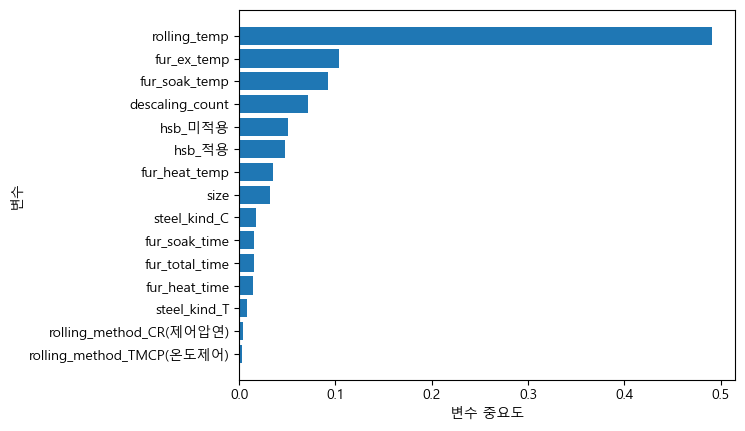

In [582]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [ ]:
rf_final = RandomForestClassifier(random_state=1234, n_estimators=100, min_samples_leaf=2,
                                min_samples_split=3, max_depth=4)

rf_final.fit(df_train_x, df_train_y)

y_pred = rf_final.predict(df_test_x)

# train 모델 정확도
print("Accurcy on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))

# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))



## 4. 그라디언트 부스팅

In [583]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [584]:
# 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

df_raw_x = df_raw_dummy.drop('scale', axis =1, inplace = False)
df_raw_y = df_raw_dummy['scale']

In [585]:
#데이터는 (train(0.6) : test(0.4))의 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (692, 15)
train data Y size: (692,)
test data X size: (297, 15)
test data Y size: (297,)


In [586]:
# 모델 생성 : GradientboostingRegressor
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.993


In [594]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    "max_depth": sp_randint(1, 20),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "max_features": uniform(0.01, 1.0),
    "learning_rate": uniform(0.01, 1.0),
}

gb = GradientBoostingClassifier(n_estimators=100)

random_gb = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, cv=3, scoring="r2", random_state=42)
random_gb.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(random_gb.best_estimator_))
print("\nbest parameter: \n{}".format(random_gb.best_params_))
print("\nbest score: \n{}".format(random_gb.best_score_.round(3)))


best estimator model: 
GradientBoostingClassifier(learning_rate=0.7653614103176525, max_depth=6,
                           max_features=0.21794166286818883, min_samples_leaf=4,
                           min_samples_split=19)

best parameter: 
{'learning_rate': 0.7653614103176525, 'max_depth': 6, 'max_features': 0.21794166286818883, 'min_samples_leaf': 4, 'min_samples_split': 19}

best score: 
0.94


In [605]:
gb_final = GradientBoostingClassifier(min_samples_leaf=4,max_depth=6, n_estimators=100,learning_rate=0.7, random_state=1234 )

gb_final.fit(df_train_x, df_train_y)

y_pred = gb_final.predict(df_test_x)

# train 모델 정확도
print("Accurcy on training set: {:.3f}".format(gb_final.score(df_train_x,df_train_y)))

# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x,df_test_y)))
gb_confusion = confusion_matrix(df_test_y, y_pred)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
gb_creport = classification_report(df_test_y, y_pred, digits=3)
print(classification_report(df_test_y, y_pred, digits=3))

Accurcy on training set: 1.000
Accuracy on test set: 0.997
Confusion matrix: 
[[209   0]
 [  1  87]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       209
           1      1.000     0.989     0.994        88

    accuracy                          0.997       297
   macro avg      0.998     0.994     0.996       297
weighted avg      0.997     0.997     0.997       297



In [606]:
# 변수명 저장
v_feature_name = df_train_x.columns


# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
6,rolling_temp,0.530
7,descaling_count,0.162
2,fur_soak_temp,0.147
11,hsb_미적용,0.142
12,hsb_적용,0.016
4,fur_total_time,0.001
0,fur_heat_temp,0.001
5,fur_ex_temp,0.001
3,fur_soak_time,0.000
1,fur_heat_time,0.000


Text(0, 0.5, '변수')

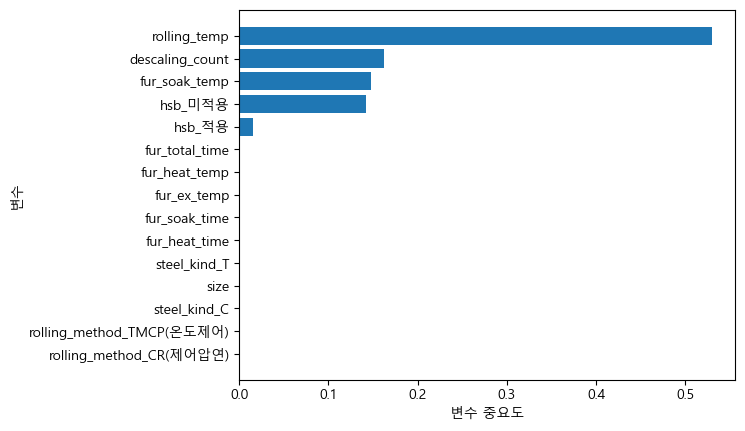

In [607]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 5. 서포트 벡터 머신

In [608]:
# 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

df_raw_x = df_raw_dummy.drop('scale', axis =1, inplace = False)
df_raw_y = df_raw_dummy['scale']

#데이터는 (train(0.6) : test(0.4))의 비율로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (692, 15)
train data Y size: (692,)
test data X size: (297, 15)
test data Y size: (297,)


In [609]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.682
Accuracy on test set: 0.704


In [ ]:
param_dist = {
    "C": uniform(0.01, 10.0),
    "kernel": ["linear", "rbf", "poly"],
    "gamma": uniform(0.01, 1.0),
}

svm = SVC()

random_svm = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=3, scoring="accuracy", random_state=42)
random_svm.fit(df_train_x, df_train_y)

print("best estimator model:\n{}".format(random_svm.best_estimator_))
print("\nbest parameter:\n{}".format(random_svm.best_params_))
print("\nbest score:\n{}".format(random_svm.best_score_.round(3)))

In [ ]:
svc_final = SVC(gamma = 0.15, C = 1.3, random_state = 1234)
svc_final.fit(df_scaled_train_x, df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)

print("Accuracy on training set: {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svc_final.score(df_scaled_test_x, df_test_y)))
svm_confusion = confusion_matrix(df_test_y, y_pred)
print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))
svm_creport = classification_report(df_test_y, y_pred, digits = 3)
print(classification_report(df_test_y, y_pred, digits = 3))

# 결론

In [ ]:
# scale + 하나의 항목 제거
print("Logistic Confusion matrix : \n{}".format(logit_confusion))
print(logit_creport)

In [ ]:
# smote
print("Decision Tree Confusion matrix : \n{}".format(dt_confusion))
print(dt_creport)

In [ ]:
print("RandomForest Confusion matrix : \n{}".format(rf_confusion))
print(rf_creport)

In [ ]:
print("GradientBoosting Confusion matrix : \n{}".format(gb_confusion))
print(gb_creport)

In [ ]:
print("SVM Confusion matrix : \n{}".format(svm_confusion))
print(svm_creport)